# Backtesting Strategies

In [1]:
def DataLoder_BuySell(path):
    """
    Load and preprocess stock data from a CSV file (downloaded via yfinance).

    Parameters:
    - path (str): File path to the CSV data.

    Returns:
    - pd.DataFrame: Cleaned and formatted stock data with 'Date' as the index.
                    Returns 0 if the file doesn't exist or an error occurs.

    Processing Steps:
    - Checks if the file exists
    - Converts 'Date' to datetime format
    - Converts all other columns to float
    - Sets 'Date' as the index
    """
    import pandas as pd
    import numpy as np
    import os

    try:
        # Check if file exists
        isExist = os.path.exists(path)
        if not isExist:
            return 0
        
        # Load CSV data
        stock_data = pd.read_csv(path)
    
        # Convert 'Date' column to datetime
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])

        # Convert all other columns to float
        ignore = ['Date']
        stock_data = (
            stock_data.set_index(ignore, append=True)
                      .astype(float)
                      .reset_index(ignore)
        )

        # Set 'Date' as the DataFrame index
        stock_data.set_index('Date', inplace=True)

        return stock_data
    except:
        # Catch all errors and return 0
        print("Error occurred while loading data...")
        return 0

In [2]:
stryker_buy_sell = DataLoder_BuySell('../data/Stryker_buy_sell_signal_MACD_BB.csv')

In [3]:
stryker_buy_sell.head()

,Close,High,Low,Open,Volume,MACD,Signal_Line,MACD_Hist,BB_Middle,BB_Lower,BB_Upper,Buy_signal_MACD_BB,Sell_signal_MACD_BB
Date,,,,,,,,,,,,,
2019-04-01,183.808014,187.322955,183.208131,186.760559,1625900.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.0,0.0
2019-04-02,182.936279,184.107926,182.617595,183.714255,919700.0,-0.069540,-0.013908,-0.055632,NaN,NaN,NaN,0.0,0.0
2019-04-03,182.626953,184.539089,181.923965,183.967325,1154700.0,-0.147906,-0.040708,-0.107199,NaN,NaN,NaN,0.0,0.0
2019-04-04,181.567795,183.198718,181.202242,182.955021,729200.0,-0.292110,-0.090988,-0.201122,NaN,NaN,NaN,0.0,0.0
2019-04-05,183.001892,183.714248,181.633402,182.120811,640100.0,-0.287360,-0.130262,-0.157098,NaN,NaN,NaN,0.0,0.0


In [4]:
stryker_buy_sell.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1533 entries, 2019-04-01 to 2025-05-05
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                1533 non-null   float64
 1   High                 1533 non-null   float64
 2   Low                  1533 non-null   float64
 3   Open                 1533 non-null   float64
 4   Volume               1533 non-null   float64
 5   MACD                 1533 non-null   float64
 6   Signal_Line          1533 non-null   float64
 7   MACD_Hist            1533 non-null   float64
 8   BB_Middle            1514 non-null   float64
 9   BB_Lower             1514 non-null   float64
 10  BB_Upper             1514 non-null   float64
 11  Buy_signal_MACD_BB   1533 non-null   float64
 12  Sell_signal_MACD_BB  1533 non-null   float64
dtypes: float64(13)
memory usage: 167.7 KB


In [5]:
initial_capital = 1000
capital = initial_capital
shares = 0
equity_curve = []
buy_col= 'Buy_signal_MACD_BB'
sell_col = 'Sell_signal_MACD_BB'

In [6]:
for i in range(len(stryker_buy_sell)):
    row = stryker_buy_sell.iloc[i]
    price = row['Close']

    # Buy logic
    if row[buy_col] == 1 and shares == 0:
        shares = capital // price
        capital -= shares * price
        print(f"🟢 Buy @ {price:.2f} | Shares: {shares}")

        # Sell logic
    elif row[sell_col] == 1 and shares > 0:
        capital += shares * price
        print(f"🔴 Sell @ {price:.2f} | Capital: {capital:.2f}")
        shares = 0

        # Track current portfolio value
    total_value = capital + (shares * price)
    equity_curve.append(total_value)

stryker_buy_sell['Equity'] = equity_curve
final_value = equity_curve[-1]
print(f"✅ Final Portfolio Value: ${final_value:.2f}")

🟢 Buy @ 197.59 | Shares: 5.0
🔴 Sell @ 200.41 | Capital: 1014.09
🟢 Buy @ 219.49 | Shares: 4.0
🔴 Sell @ 246.95 | Capital: 1123.94
🟢 Buy @ 321.59 | Shares: 3.0
🔴 Sell @ 393.97 | Capital: 1341.09
✅ Final Portfolio Value: $1341.09


In [7]:
import matplotlib.pyplot as plt

def plot_equity(stock_data, stock_name):
    plt.figure(figsize=(12, 5))
    plt.plot(stock_data['Equity'], label='Equity Curve')
    plt.title(f'{stock_name} Strategy Equity Curve')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

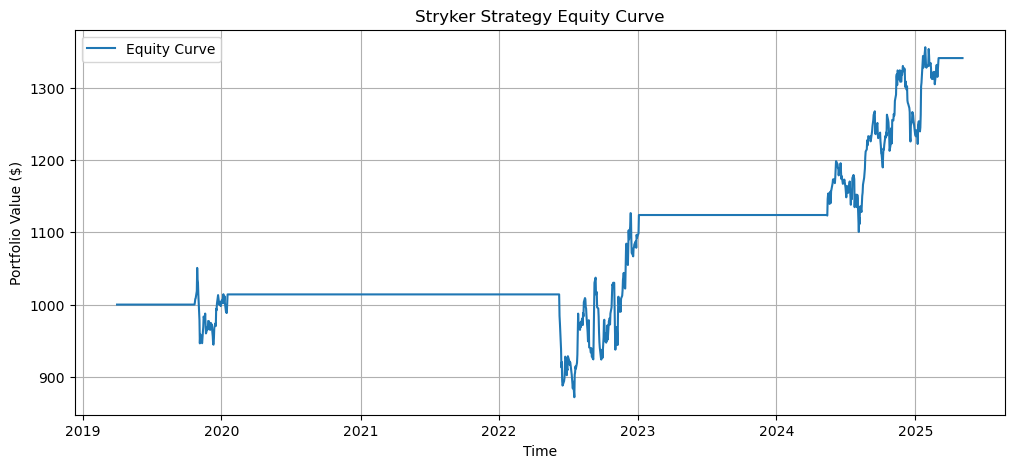

In [8]:
plot_equity(stryker_buy_sell,'Stryker')

### Backtest Strategy Function

In [9]:
def backtest_strategy(stock_data, buy_col='Buy', sell_col='Sell', initial_captial=10000):
    """
    Simulates trading a strategy based on buy/sell signal columns.
    Tracks equity curve and prints trade events.

    Parameters:
    - stock_data: DataFrame with 'Close' price and buy/sell signal columns
    - buy_col: Column name for buy signals (default: 'Buy')
    - sell_col: Column name for sell signals (default: 'Sell')
    - initial_captial: Starting capital (default: $10,000)

    Returns:
    - stock_data with an added 'Equity' column representing portfolio value over time
    """
    
    # Initialize portfolio state
    capital = initial_captial        # Starting cash
    shares = 0                       # Number of shares currently held
    equity_curve = []                # Track portfolio value each day

    # Iterate through each row (day) in the stock data
    for i in range(len(stock_data)):
        row = stock_data.iloc[i]     # Get data for current day
        price = row['Close']         # Use closing price for trades

        # --- Buy Logic ---
        if row[buy_col] == 1 and shares == 0:
            # Buy as many shares as possible
            shares = capital // price
            capital -= shares * price
            print(f"🟢 Buy @ {price:.2f} | Shares: {shares}")

        # --- Sell Logic ---
        elif row[sell_col] == 1 and shares > 0:
            # Sell all shares at current price
            capital += shares * price
            print(f"🔴 Sell @ {price:.2f} | Capital: {capital:.2f}")
            shares = 0

        # --- Portfolio Value Update ---
        total_value = capital + (shares * price)  # Cash + market value of held shares
        equity_curve.append(total_value)          # Track portfolio value on this day

    # Add equity curve to DataFrame for plotting/evaluation
    stock_data['Equity'] = equity_curve

    # Print final portfolio value after simulation
    final_value = equity_curve[-1]
    print(f"✅ Final Portfolio Value: {final_value:.2f}")

    return stock_data

### Equity Curve Plotting Function

In [10]:
def plot_equity(stock_data, stock_name):
    """
    Plot the equity curve (portfolio value over time) for a backtested strategy.

    Parameters:
    - stock_data: DataFrame with an 'Equity' column created by backtest_strategy().
    - stock_name: String, name of the stock or strategy to show in the chart title.

    Returns:
    - None (displays matplotlib plot)
    """

    import matplotlib.pyplot as plt

    # Safety check: ensure 'Equity' column exists
    if 'Equity' not in stock_data.columns:
        raise ValueError("The DataFrame does not contain an 'Equity' column. Run backtest_strategy() first.")

    # Create the figure
    plt.figure(figsize=(12, 5))
    plt.plot(stock_data['Equity'], label='Equity Curve', linewidth=2)

    # Title and labels
    plt.title(f'{stock_name} Strategy Equity Curve', fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value ')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()

🟢 Buy @ 197.59 | Shares: 50.0
🔴 Sell @ 200.41 | Capital: 10140.87
🟢 Buy @ 219.49 | Shares: 46.0
🔴 Sell @ 246.95 | Capital: 11404.12
🟢 Buy @ 321.59 | Shares: 35.0
🔴 Sell @ 393.97 | Capital: 13937.54
✅ Final Portfolio Value: 13937.54


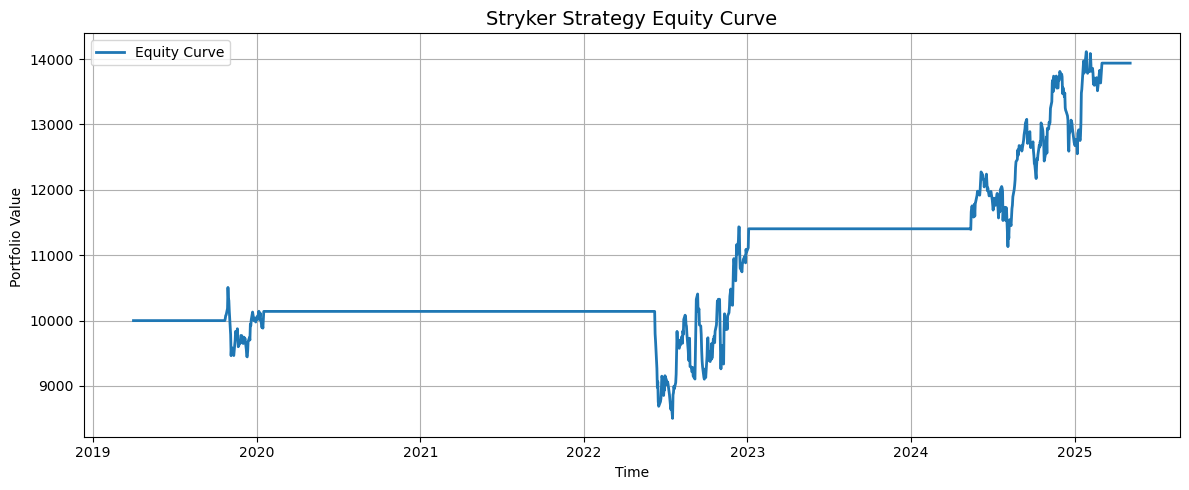

In [11]:
# Becktest Stryker Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Stryker_buy_sell_signal_MACD_BB.csv'),
                                          buy_col='Buy_signal_MACD_BB',
                                          sell_col='Sell_signal_MACD_BB',
                                          initial_captial=10000),
            stock_name='Stryker')

🟢 Buy @ 174.29 | Shares: 57.0
🔴 Sell @ 198.25 | Capital: 11365.62
🟢 Buy @ 191.16 | Shares: 59.0
🔴 Sell @ 240.39 | Capital: 14270.11
🟢 Buy @ 246.08 | Shares: 57.0
🔴 Sell @ 381.43 | Capital: 21984.83
✅ Final Portfolio Value: 21984.83


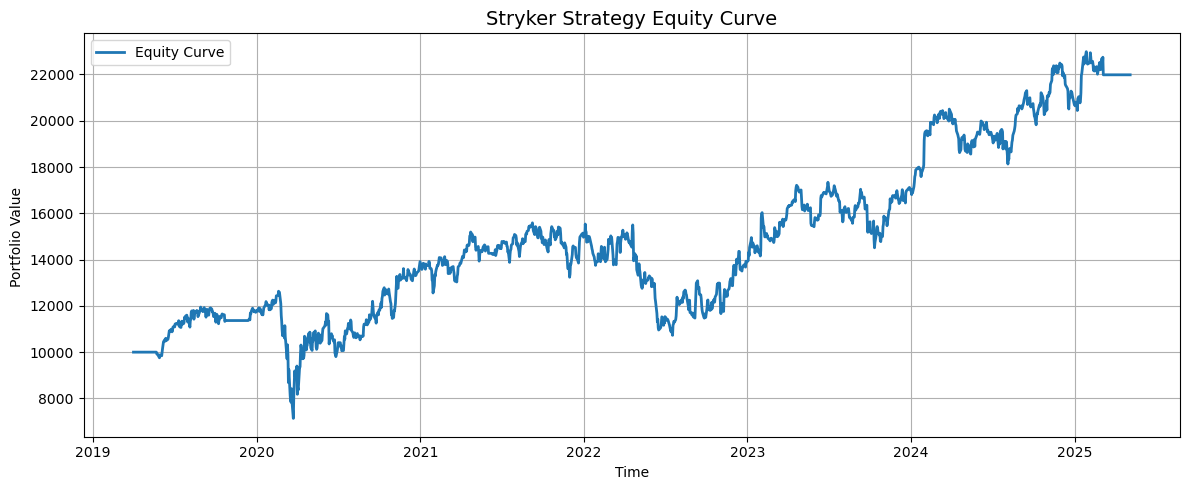

In [12]:
# Becktest Stryker Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Stryker_buy_sell_signal_MACD_BB_Advanced.csv'),
                                          buy_col='Buy_Signal_Combo',
                                          sell_col='Sell_Signal_Combo',
                                          initial_captial=10000),
            stock_name='Stryker')

✅ Final Portfolio Value: 10000.00


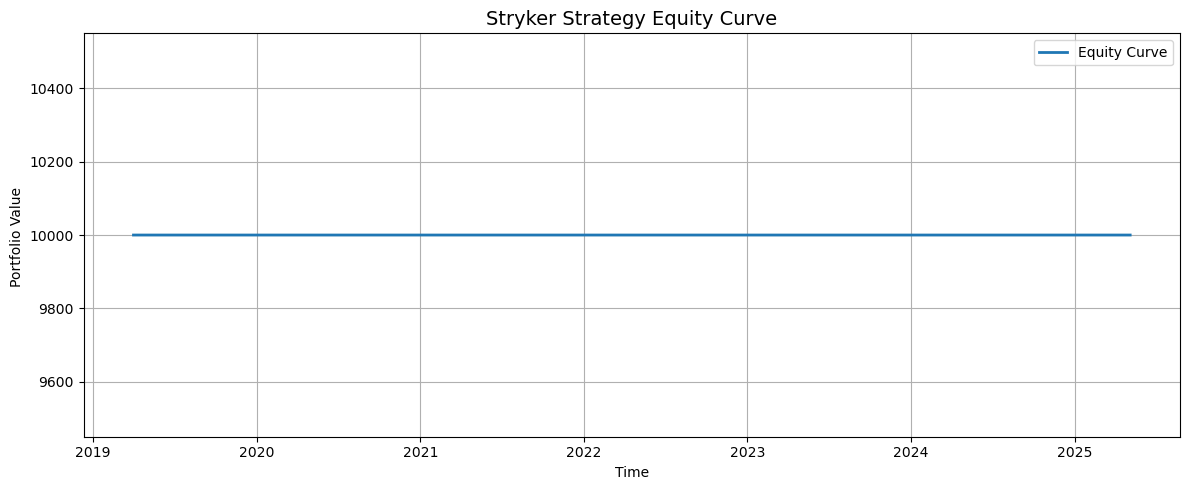

In [13]:
# Becktest Stryker Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Stryker_buy_sell_signal_Multi.csv'),
                                          buy_col='Buy_Multi',
                                          sell_col='Sell_Multi',
                                          initial_captial=10000),
            stock_name='Stryker')

🟢 Buy @ 1230.94 | Shares: 8.0
🔴 Sell @ 1316.01 | Capital: 10680.56
🟢 Buy @ 1302.00 | Shares: 8.0
✅ Final Portfolio Value: 11713.36


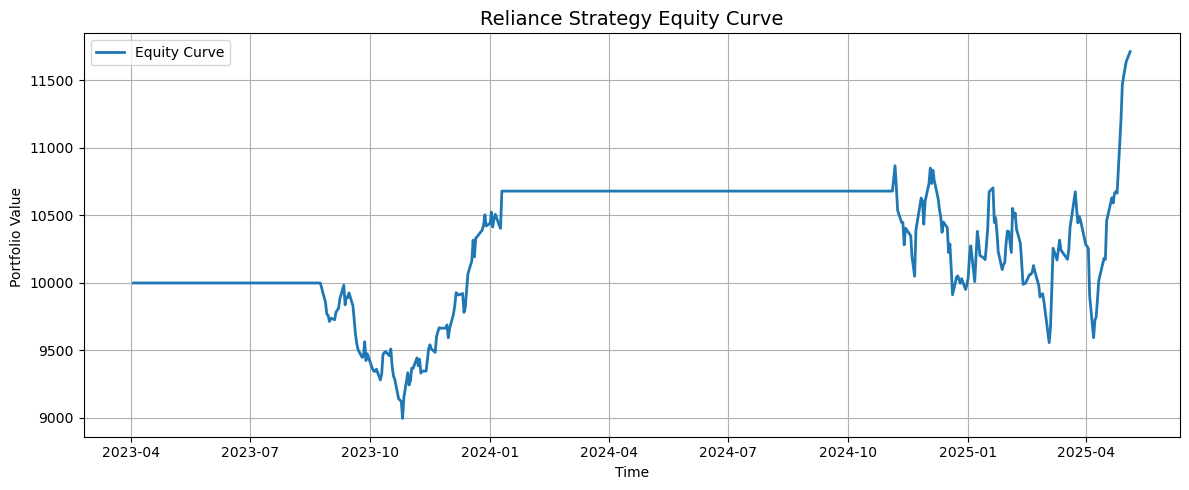

In [14]:
# Becktest Reliance Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/RELIANCE_buy_sell_signal_MACD_BB.csv'),
                                          buy_col='Buy_signal_MACD_BB',
                                          sell_col='Sell_signal_MACD_BB',
                                          initial_captial=10000),
            stock_name='Reliance')

🟢 Buy @ 18598.65 | Shares: 10.0
🔴 Sell @ 18599.00 | Capital: 200003.50
🟢 Buy @ 18726.40 | Shares: 10.0
🔴 Sell @ 18563.40 | Capital: 198373.50
🟢 Buy @ 18856.85 | Shares: 10.0
🔴 Sell @ 18771.25 | Capital: 197517.50
🟢 Buy @ 19189.05 | Shares: 10.0
🔴 Sell @ 19624.70 | Capital: 201873.98
🟢 Buy @ 21930.50 | Shares: 9.0
🔴 Sell @ 21717.95 | Capital: 199961.03
🟢 Buy @ 22040.70 | Shares: 9.0
🔴 Sell @ 21951.15 | Capital: 199155.09
🟢 Buy @ 22405.60 | Shares: 8.0
🔴 Sell @ 21997.70 | Capital: 195891.88
🟢 Buy @ 22462.00 | Shares: 8.0
🔴 Sell @ 22302.50 | Capital: 194615.88
🟢 Buy @ 22529.05 | Shares: 8.0
🔴 Sell @ 23883.45 | Capital: 205451.07
✅ Final Portfolio Value: 205451.07


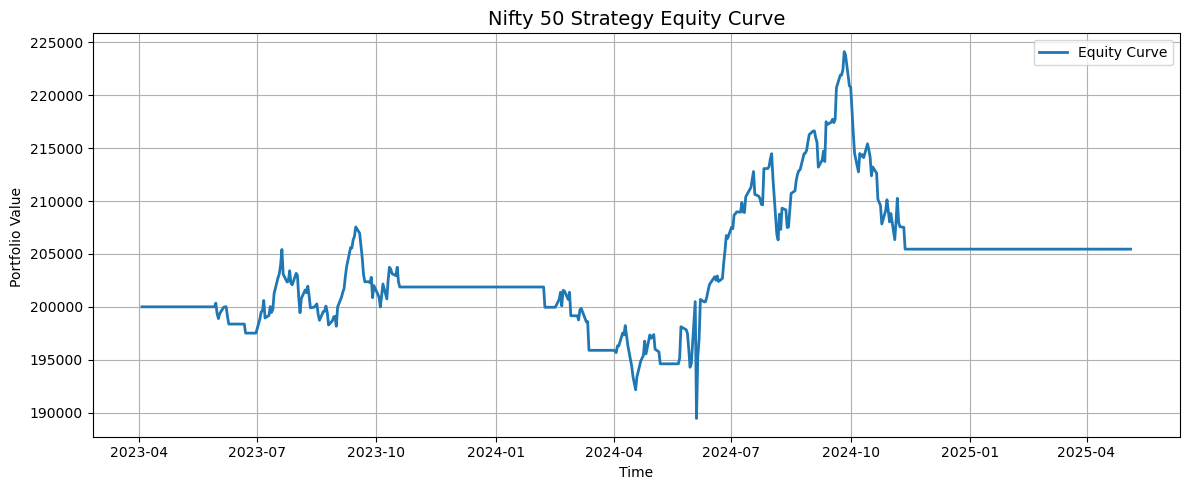

In [15]:
# Becktest Nifty 50 Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Nifty 50_buy_sell_signal_MACD_BB_Advanced.csv'),
                                          buy_col='Buy_Signal_Combo',
                                          sell_col='Sell_Signal_Combo',
                                          initial_captial=200000),
            stock_name='Nifty 50')

🟢 Buy @ 625.32 | Shares: 159.0
✅ Final Portfolio Value: 113225.57


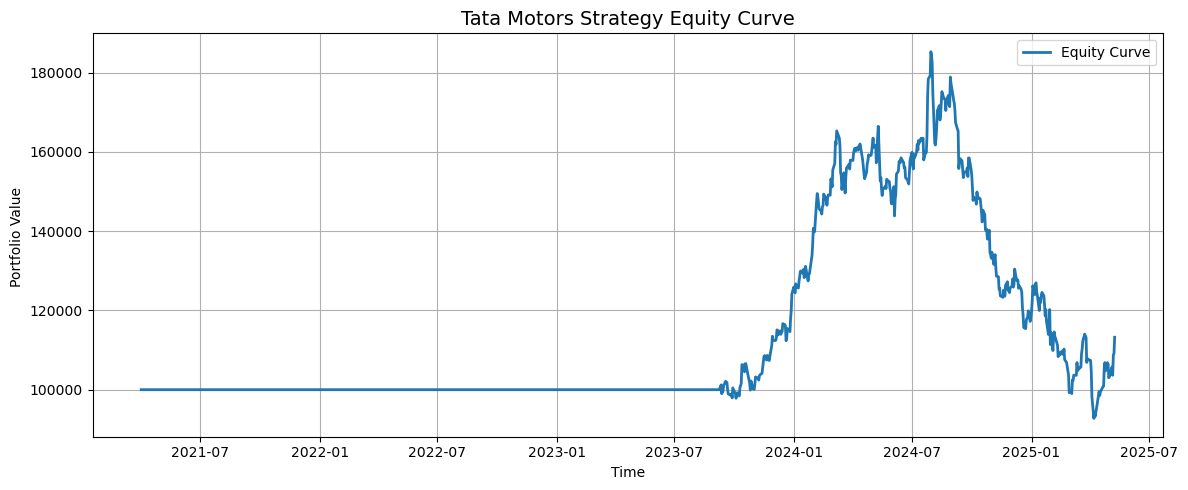

In [16]:
# Becktest Tata Motors Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Tata Motors_buy_sell_signal_MACD_BB_Advanced.csv'),
                                          buy_col='Buy_Signal_Combo',
                                          sell_col='Sell_Signal_Combo',
                                          initial_captial=100000),
            stock_name='Tata Motors')

✅ Final Portfolio Value: 100000.00


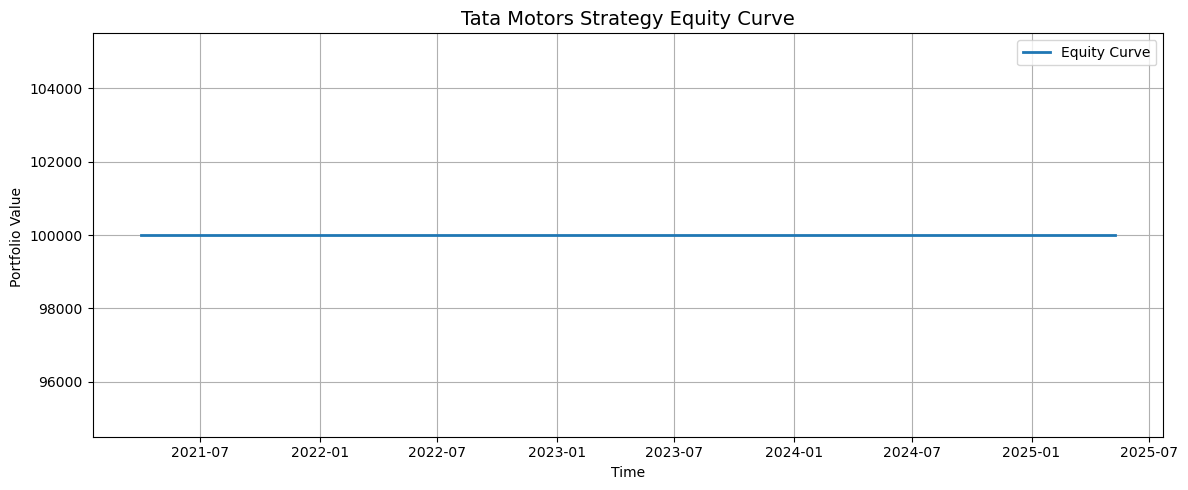

In [17]:
# Becktest Tata Motors Stock Data
plot_equity(stock_data= backtest_strategy(stock_data=DataLoder_BuySell('../data/Tata Motors_buy_sell_signal_multi.csv'),
                                          buy_col='Buy_Multi',
                                          sell_col='Sell_Multi',
                                          initial_captial=100000),
            stock_name='Tata Motors')

### Generate Detailed Trade Logs

In [18]:
def generate_trade_logs(stock_data, buy_col= None,sell_col= None):
    
    import re
    import pandas as pd
    #define regex
    buy_pattern = re.compile(r'buy.*',re.IGNORECASE)
    sell_pattern = re.compile(r'sell.*',re.IGNORECASE)
    
    # Auto Detect columns
    if not buy_col or buy_col not in stock_data.columns:
        buy_col = next(
            (col for col in stock_data.columns if buy_pattern.search(col)), None)
    
    if not sell_col or sell_col not in stock_data.columns:
        sell_col = next(
            (col for col in stock_data.columns if sell_pattern.search(col)), None)
    
    if not buy_col or not sell_col:
        raise ValueError("Buy/Sell signal columns not found. Use manual override.")
    
    print(f"✅ Auto-Detected → Buy: '{buy_col}' | Sell: '{sell_col}'")
    
    # --- Trade Log Logic ---
    trades = []
    in_trade = False
    entry_date , entry_price, entry_index = None , None ,None
    
    for i in range(len(stock_data)):
        row = stock_data.iloc[i]
        
        if not in_trade and row[buy_col] == 1:
            entry_date = stock_data.index[i]
            entry_price = row['Close']
            entry_index = i
            in_trade = True
        
        elif in_trade and row[sell_col] == 1:
            exit_date = stock_data.index[i]
            exit_price = row['Close']
            return_pct = ((exit_price - entry_price)/ entry_price)*100
            holding_period = i - entry_index
            
            trades.append({
                'Entry Date':entry_date,
                'Exit Date': exit_date,
                'Entry Price': round(entry_price,2),
                'Exit Price': round(exit_price,2),
                'Return (%)': round(return_pct,2),
                'Holding Period (days)': holding_period
            })
            in_trade =False # Reset
    return pd.DataFrame(trades)
    

In [19]:
trade_logs = generate_trade_logs(stock_data=DataLoder_BuySell('../data/Stryker_buy_sell_signal_MACD_BB_Advanced.csv'))

✅ Auto-Detected → Buy: 'Buy_Signal_Combo' | Sell: 'Sell_Signal_Combo'


In [20]:
trade_logs

,Entry Date,Exit Date,Entry Price,Exit Price,Return (%),Holding Period (days)
0,2019-05-22,2019-10-23,174.29,198.25,13.75,107
1,2019-12-13,2021-06-02,191.16,240.39,25.75,368
2,2021-06-10,2025-03-06,246.08,381.43,55.00,938


### Strategy Evaluation Metrics

In [21]:
def evaluate_strategy(trade_log):
    if trade_log.empty:
        print("⚠️ No trades were executed. Evaluation skipped.")
        return {
            'Total Trades': 0,
            'Win Rate (%)': 0,
            'Avg Return (%)': 0,
            'Max Drawdown (%)': 0,
            'Risk-Reward Ratio': 0
        }

    total_trades = len(trade_log)
    wins = trade_log[trade_log['Return (%)'] > 0]
    losses = trade_log[trade_log['Return (%)'] <= 0]

    win_rate = len(wins) / total_trades * 100 if total_trades else 0
    avg_return = trade_log['Return (%)'].mean()
    max_drawdown = trade_log['Return (%)'].min()
    avg_win = wins['Return (%)'].mean() if not wins.empty else 0
    avg_loss = losses['Return (%)'].mean() if not losses.empty else 0
    rr_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')

    print(f"📊 Total Trades       : {total_trades}")
    print(f"✅ Win Rate          : {win_rate:.2f}%")
    print(f"📈 Avg Return/Trade  : {avg_return:.2f}%")
    print(f"⚠️ Max Drawdown      : {max_drawdown:.2f}%")
    print(f"⚖️  Risk-Reward Ratio: {rr_ratio:.2f}")
    print(f"⏳ Avg Hold Duration : {trade_log['Holding Period (days)'].mean():.1f} days")

    return {
        'Total Trades': total_trades,
        'Win Rate (%)': win_rate,
        'Avg Return (%)': avg_return,
        'Max Drawdown (%)': max_drawdown,
        'Risk-Reward Ratio': rr_ratio
    }

In [22]:
evaluate_strategy(trade_logs)

📊 Total Trades       : 3
✅ Win Rate          : 100.00%
📈 Avg Return/Trade  : 31.50%
⚠️ Max Drawdown      : 13.75%
⚖️  Risk-Reward Ratio: inf
⏳ Avg Hold Duration : 471.0 days


{'Total Trades': 3,
 'Win Rate (%)': 100.0,
 'Avg Return (%)': 31.5,
 'Max Drawdown (%)': 13.75,
 'Risk-Reward Ratio': inf}

### Backtest with Logs

In [23]:
def detect_buy_sell_columns(stock_data, buy_col=None, sell_col=None):
    """
    Auto-detect Buy/Sell signal columns using regex, unless explicitly provided.

    Parameters:
    - stock_data (pd.DataFrame): The DataFrame to search in.
    - buy_col (str or None): Column name for buy signals (manual override).
    - sell_col (str or None): Column name for sell signals (manual override).

    Returns:
    - (buy_col, sell_col): Detected or confirmed column names.
    """
    
    import re
    
    # Define regex patterns to match column names like 'Buy_Multi', 'buy_signal', etc.
    buy_pattern = re.compile(r'buy.*', re.IGNORECASE)
    sell_pattern = re.compile(r'sell.*', re.IGNORECASE)

    # Auto-detect buy column if not specified or invalid
    if not buy_col or buy_col not in stock_data.columns:
        buy_col = next((col for col in stock_data.columns if buy_pattern.search(col)), None)

    # Auto-detect sell column if not specified or invalid
    if not sell_col or sell_col not in stock_data.columns:
        sell_col = next((col for col in stock_data.columns if sell_pattern.search(col)), None)

    # Error handling if either column is missing
    if not buy_col or not sell_col:
        raise ValueError("❌ Buy/Sell signal columns not found. Use manual override.")

    print(f"✅ Auto-Detected → Buy: '{buy_col}' | Sell: '{sell_col}'")
    return buy_col, sell_col

In [24]:
def backtest_with_log(stock_data, stock_name='stock', buy_col=None, sell_col= None, initial_capital=10000, export_csv=True):
    """
    Run a backtest based on buy/sell signals and generate a trade log + equity curve.
    Auto-detect Buy/Sell signal columns using regex, unless explicitly provided.
    
    Parameters:
    - df: DataFrame with signals
    - stock_name: Used for naming export file
    - buy_col, sell_col: Column names for buy/sell signals (1 = signal triggered)
    - initial_capital: Starting capital
    - export_csv: If True, saves trade log to CSV
    
    Returns:
    - df: DataFrame with added Equity column
    - trade_log: DataFrame with all executed trades
    """
    import re
    import pandas as pd
    
    capital = initial_capital
    shares = 0
    equity_curve = []
    trades = []
    
    # get buy_col & sell_col name
    buy_col, sell_col = detect_buy_sell_columns(stock_data)
    
    in_trade = False
    entry_price = 0
    entry_date = None
    entry_index = 0

    for i in range(len(stock_data)):
        row = stock_data.iloc[i]
        date = stock_data.index[i]
        price = row['Close']

        # Buy
        if not in_trade and row[buy_col] == 1:
            shares = capital // price
            capital -= shares * price
            entry_price = price
            entry_date = date
            entry_index = i
            in_trade = True

        # Sell
        elif in_trade and row[sell_col] == 1:
            capital += shares * price
            return_pct = ((price - entry_price) / entry_price) * 100
            trades.append({
                'Entry Date': entry_date,
                'Exit Date': date,
                'Entry Price': round(entry_price, 2),
                'Exit Price': round(price, 2),
                'Return (%)': round(return_pct, 2),
                'Holding Period (days)': i - entry_index
            })
            shares = 0
            in_trade = False

        # Track equity
        total_value = capital + (shares * price)
        equity_curve.append(total_value)

    # Save to DataFrame
    stock_data['Equity'] = equity_curve
    trade_log = pd.DataFrame(trades)

    # Export trade log
    if export_csv and not trade_log.empty:
        filename = f"../data/{stock_name}_trade_log.csv"
        trade_log.to_csv(filename, index=False)
        print(f"📁 Trade log exported as '{filename}'")

    return stock_data, trade_log

In [25]:
stock_data , trade_log = backtest_with_log(stock_data=DataLoder_BuySell('../data/Stryker_buy_sell_signal_MACD_BB_Advanced.csv'),
                                           stock_name="Stryker"
                                           ,export_csv=True)
trade_log

✅ Auto-Detected → Buy: 'Buy_Signal_Combo' | Sell: 'Sell_Signal_Combo'
📁 Trade log exported as '../data/Stryker_trade_log.csv'


,Entry Date,Exit Date,Entry Price,Exit Price,Return (%),Holding Period (days)
0,2019-05-22,2019-10-23,174.29,198.25,13.75,107
1,2019-12-13,2021-06-02,191.16,240.39,25.75,368
2,2021-06-10,2025-03-06,246.08,381.43,55.00,938


In [26]:
evaluate_strategy(trade_log)

📊 Total Trades       : 3
✅ Win Rate          : 100.00%
📈 Avg Return/Trade  : 31.50%
⚠️ Max Drawdown      : 13.75%
⚖️  Risk-Reward Ratio: inf
⏳ Avg Hold Duration : 471.0 days


{'Total Trades': 3,
 'Win Rate (%)': 100.0,
 'Avg Return (%)': 31.5,
 'Max Drawdown (%)': 13.75,
 'Risk-Reward Ratio': inf}

## Strategy Comparison with Performance Dashboard

### Define Strategy Metadata

In [27]:
strategies = {
    "MACD_BB": {
        "file": "../data/Stryker_buy_sell_signal_MACD_BB.csv",
        "buy_col":'Buy_signal_MACD_BB',
        "sell_col":'Sell_signal_MACD_BB'
    },
    "MACD_BB_Advance": {
        "file": "../data/Stryker_buy_sell_signal_MACD_BB_Advanced.csv",
        "buy_col":'Buy_Signal_Combo',
        "sell_col":'Sell_Signal_Combo'
    },
    "Multi_Idicators": {
        "file": "../data/Tata Motors_buy_sell_signal_multi.csv",
        "buy_col":'Buy_Multi',
        "sell_col":'Sell_Multi'
    }
}

### Evaluation function for CSV-based Strategies

In [28]:
def evaluate_csv_strategies(strategies_dict, initial_capital =10000):
    
    import pandas as pd
    
    metrics_dict = {}
    equity_curves = {}
    
    for name,info in strategies_dict.items():
        #Load each Strategy CSV
        stock_data = DataLoder_BuySell(info["file"])
        
        # Run backtest
        stock_data , trade_logs = backtest_with_log(stock_data,
                                                   buy_col=info['buy_col'],
                                                   sell_col=info['sell_col'],
                                                   initial_capital= initial_capital,
                                                   export_csv= False)
        # Save Equity for plotting
        equity_curves[name] = stock_data["Equity"]
        
        # Save Performance metrics
        metrics_dict[name]=evaluate_strategy(trade_logs)
        print(name)
        #print(equity_curve)
    
    return metrics_dict , pd.DataFrame(equity_curves)

In [29]:
# Export strategy performance summary
def export_strategy_summary(metrics_dict, filename='../data/strategy_summary.csv'):
    import pandas as pd
    
    summary_df = pd.DataFrame(metrics_dict).T
    summary_df.to_csv(filename)
    print(f"📊 Exported strategy summary → {filename}")

In [30]:
# Plot Equity Curves

def plot_equity_comparison(equity_df):
    import matplotlib.pyplot as plt
    
    print("Columns: ",equity_df.columns)
    plt.figure(figsize=(12,6))
    
    for col in equity_df.columns:
        print(col)
        plt.plot(equity_df[col], label = col)
    
    plt.title("Strategy Equity Curve Comparison")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

✅ Auto-Detected → Buy: 'Buy_signal_MACD_BB' | Sell: 'Sell_signal_MACD_BB'
📊 Total Trades       : 3
✅ Win Rate          : 100.00%
📈 Avg Return/Trade  : 12.15%
⚠️ Max Drawdown      : 1.43%
⚖️  Risk-Reward Ratio: inf
⏳ Avg Hold Duration : 134.7 days
MACD_BB
✅ Auto-Detected → Buy: 'Buy_Signal_Combo' | Sell: 'Sell_Signal_Combo'
📊 Total Trades       : 3
✅ Win Rate          : 100.00%
📈 Avg Return/Trade  : 31.50%
⚠️ Max Drawdown      : 13.75%
⚖️  Risk-Reward Ratio: inf
⏳ Avg Hold Duration : 471.0 days
MACD_BB_Advance
✅ Auto-Detected → Buy: 'Buy_Multi' | Sell: 'Sell_Multi'
⚠️ No trades were executed. Evaluation skipped.
Multi_Idicators
📊 Exported strategy summary → ../data/strategy_summary.csv
Columns:  Index(['MACD_BB', 'MACD_BB_Advance', 'Multi_Idicators'], dtype='object')
MACD_BB
MACD_BB_Advance
Multi_Idicators


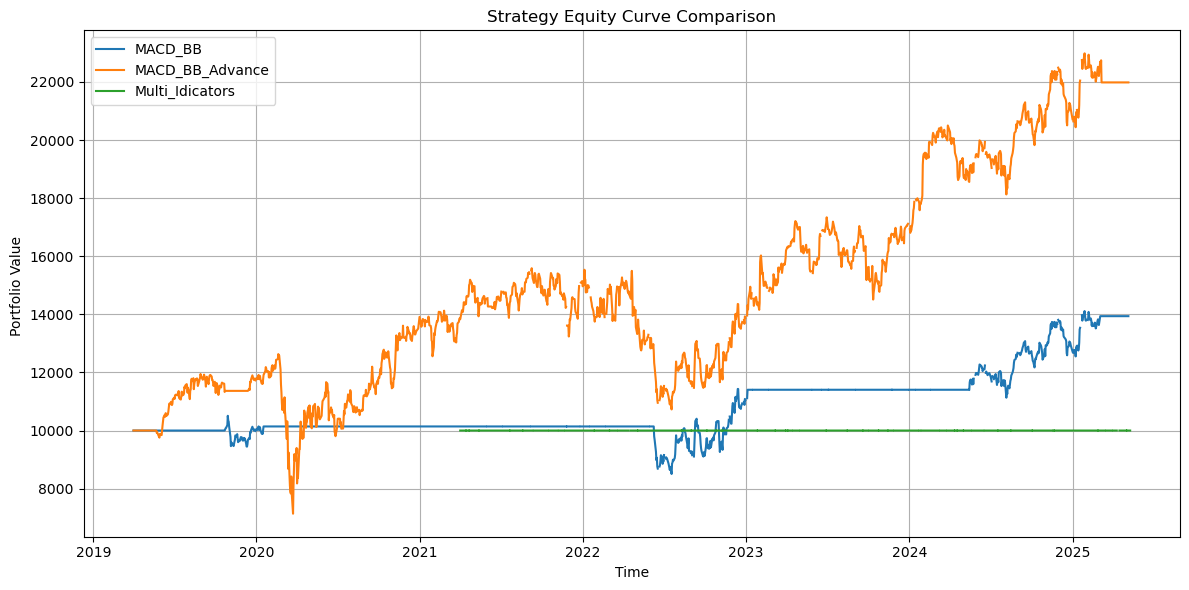

In [31]:
# Run the full evaluation process
metrics_dict, equity_df = evaluate_csv_strategies(strategies)

# Export summary
export_strategy_summary(metrics_dict)

# Plot equity curves
plot_equity_comparison(equity_df)